# Tinder profile generation with RNNs



Part of the Tinder profile generation project
This section handles the profile text generation using LSTMs
we use the kaggle TInder dataset at https://www.kaggle.com/immune/tinder-profiles


Based primary on Brownlees tutorial
https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/
@author: Adrian

DONT FORGET TO GET RANDOM SEED GEN FROM TRUMP OR BROWNLEE

Brownlees tutorial helps with understanding, but for actual generation, Trump CharRNN is much more useful
https://github.com/jctestud/char-rnn/blob/master/char-rnn_trump_text_generation-TRAINING.ipynb

TLDR: Uses a certain length of chars to predict the next char in a Bio, trained on over 40K Bios

In [1]:
#Import all packages

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import warnings
import sklearn
import io
import scipy
import numpy
import json
import nltk
import sys
import csv
import os
import re
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Activation, Dense

!gdown https://drive.google.com/uc?id=1A8zyqs9j-kS1oE2xUhhFSRe0UGEtp_sc


Using TensorFlow backend.


Downloading...
From: https://drive.google.com/uc?id=1A8zyqs9j-kS1oE2xUhhFSRe0UGEtp_sc
To: /content/wine.csv
5.01MB [00:00, 15.9MB/s]


In [2]:
#Text import and preprocessing
base_dir = 'wine.csv'


tinder_profile_df = pd.read_csv(base_dir)

# Print dataframe info
tinder_profile_df.info()

print(tinder_profile_df.head())

# This will print the number of rows and columns that will be used to train
print("Shape of train set : ",tinder_profile_df.shape)

#tinder_profile_df.head()

#Convert dataframe to string already here

tinder_bios_df=tinder_profile_df['description'].apply(str)



#Print only thhe bios
print(tinder_bios_df)

#Define a generic vocabulary
# generic vocabulary
characters = list(string.printable)
characters.remove('\x0b')
characters.remove('\x0c')

VOCABULARY_SIZE = len(characters)
characters_to_ix = {c:i for i,c in enumerate(characters)}
print("vocabulary len = %d" % VOCABULARY_SIZE)
print(characters)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15092 entries, 0 to 15091
Data columns (total 11 columns):
Unnamed: 0     15092 non-null int64
country        15090 non-null object
description    15092 non-null object
designation    10747 non-null object
points         15092 non-null int64
price          14160 non-null float64
province       15090 non-null object
region_1       12821 non-null object
region_2       5871 non-null object
variety        15092 non-null object
winery         15092 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 1.3+ MB
   Unnamed: 0 country  ...             variety                   winery
0           0      US  ...  Cabernet Sauvignon                    Heitz
1           1   Spain  ...       Tinta de Toro  Bodega Carmen Rodríguez
2           2      US  ...     Sauvignon Blanc                 Macauley
3           3      US  ...          Pinot Noir                    Ponzi
4           4  France  ...  Provence red blend     Domaine de la

In [3]:
#Extract individual bios into one large string

#Usually We would pad our sequences, but a quick inspection reveals sequences are drastically different lenghts
#hence lets just join them together.
#We define a filtering function first
holder = []
for i in range(0, len(tinder_bios_df)):
    #print (tinder_bios_df.iloc[i]);
    string = tinder_bios_df.iloc[i]

    if(string== "nan"):
        print("nan detected, moving on")
    else:
        holder.append(string)

#print(holder) 

alphaholder= []
regex = re.compile('[^A-Za-z0-9 -.,]')
#now that holder is ready we remove all non alphanumeric entries
for i in range(0, len(holder)):
    string = holder[i]
    
    
    #First parameter is the replacement, second parameter is your input string
    newstring = regex.sub('', string)

    alphaholder.append(newstring)
    
    
#print(alphaholder)

#Split data into train and validation strings
trainholder=[]
validationholder=[]

print(len(alphaholder))
#Len alphaholder is 43660
for i in range(0, 12000): 
    trainstring = alphaholder[i]
    trainholder.append(trainstring)
for i in range(12000, len(alphaholder)): 
    valstring = alphaholder[i]
    validationholder.append(valstring)


#14-04-2019 Data is now ready, need to append into giant string
finalstring = ''.join(trainholder)
validationstring = ''.join(validationholder)

print(finalstring)
print(validationstring)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



**Model Building**

In [4]:
#Some variables to set here
N_GPU = 1
# you can experiment with more GPUs, it gets interesting with a high SEQUENCE_LEN
SEQUENCE_LEN = 20; 
#This is the char length of each individual sequence
#Essentially, we use 60 chars to predict the 61st char. This needs to be shorter for us
BATCH_SIZE = 512 #Number of sequences fed at once in batch
EPOCHS = 10
HIDDEN_LAYERS_DIM = 512
LAYER_COUNT = 4
DROPOUT = 0.2

text_train_len = len(finalstring)
text_val_len = len(validationstring)
def describe_batch(X, y, samples=3):
    """Describe in a human-readable format some samples from a batch.  Show the next char given previous char"""
    for i in range(samples):
        sentence = ""
        for s in range(SEQUENCE_LEN):
            sentence += characters[X[i,s,:].argmax()]
        next_char = characters[y[i,:].argmax()]
        
        print("sample #%d: ...%s -> '%s'" % (
            i,
            sentence[-20:],
            next_char
        ))
    
def batch_generator(text, count):
    """Generate batches for training"""
    while True: # keras wants that for reasons
        for batch_ix in range(count):
            X = np.zeros((BATCH_SIZE, SEQUENCE_LEN, VOCABULARY_SIZE))
            y = np.zeros((BATCH_SIZE, VOCABULARY_SIZE))

            batch_offset = BATCH_SIZE * batch_ix

            for sample_ix in range(BATCH_SIZE):
                sample_start = batch_offset + sample_ix
                for s in range(SEQUENCE_LEN):
                    X[sample_ix, s, characters_to_ix[text[sample_start+s]]] = 1
                y[sample_ix, characters_to_ix[text[sample_start+s+1]]]=1

            yield X, y
            


for ix, (X,y) in enumerate(batch_generator(finalstring, count=1)):
    # describe some samples from the first batch
    describe_batch(X, y, samples=5)
    break

sample #0: ...This tremendous 100% -> ' '
sample #1: ...his tremendous 100%  -> 'v'
sample #2: ...is tremendous 100% v -> 'a'
sample #3: ...s tremendous 100% va -> 'r'
sample #4: ... tremendous 100% var -> 'i'


In [5]:
###########################################Model Building#################################
    ###From trump char builder
def build_model(gpu_count=1):
    """Build a Keras sequential model for training the char-rnn"""
    model = Sequential()
    for i in range(LAYER_COUNT):
        model.add(
            LSTM(
                HIDDEN_LAYERS_DIM, 
                return_sequences=True if (i!=(LAYER_COUNT-1)) else False,
                input_shape=(SEQUENCE_LEN, VOCABULARY_SIZE),
            )
        )
        model.add(Dropout(DROPOUT))
    
    model.add(Dense(VOCABULARY_SIZE))
    model.add(Activation('softmax'))
    
    #removed the multigpu line
    
    model.compile(loss='categorical_crossentropy', optimizer="adam")
    return model


training_model = build_model(gpu_count=N_GPU)

train_batch_count = (text_train_len - SEQUENCE_LEN) // BATCH_SIZE
val_batch_count = (text_val_len - SEQUENCE_LEN) // BATCH_SIZE
print("training batch count: %d" % train_batch_count)
print("validation batch count: %d" % val_batch_count)


#NO CHECKPOINTING IN THIS VERSION, because of simplicity and because our dataset is much smaller

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
training batch count: 5723
validation batch count: 1459


In [6]:
history = training_model.fit_generator(
    batch_generator(finalstring, count=train_batch_count),
    train_batch_count,
    max_queue_size=1, # no more than one queued batch in RAM
    epochs=EPOCHS,
    validation_data=batch_generator(validationstring, count=val_batch_count),
    validation_steps=val_batch_count,
    initial_epoch=0
)
training_model.save('basic_LSTM_tindergenv1_4layers_30char.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
5723/5723 [==============================] - 1534s 268ms/step - loss: 1.5168 - val_loss: 1.1563
Epoch 2/10
5723/5723 [==============================] - 1520s 266ms/step - loss: 1.0724 - val_loss: 1.0235
Epoch 3/10
5723/5723 [==============================] - 1511s 264ms/step - loss: 0.9936 - val_loss: 0.9781
Epoch 4/10
5723/5723 [==============================] - 1519s 265ms/step - loss: 0.9522 - val_loss: 0.9545
Epoch 5/10
5723/5723 [==============================] - 1516s 265ms/step - loss: 0.9259 - val_loss: 0.9406
Epoch 6/10
5723/5723 [==============================] - 1509s 264ms/step - loss: 0.9072 - val_loss: 0.9298
Epoch 7/10
5723/5723 [==============================] - 1509s 264ms/step - loss: 0.8931 - val_loss: 0.9217
Epoch 8/10
5723/5723 [==============================] - 1515s 265ms/step - loss: 0.8825 - val_loss: 0.9158
Epoch 9/10
5723/5723 [==============================] - 1521s 266ms/step - loss: 0.8729 - val_lo

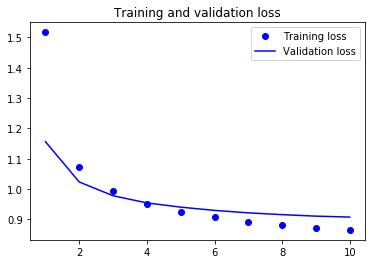

In [7]:
#############################################################################################################3
###After this we can use the trained model to predict things, and view history variables

##Plotting
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()